<a href="https://colab.research.google.com/github/ndukh/liver-segmentation/blob/master/liver_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Liver segmentation task from [CHAOS challenge](https://chaos.grand-challenge.org/Combined_Healthy_Abdominal_Organ_Segmentation/).

Unet architecture is implemented with Keras.

All the computations are made in Google colab environment.

In [1]:
!pip install medpy

In [2]:
from google.colab import auth, drive
from googleapiclient.discovery import build

auth.authenticate_user()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from PIL import Image
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, cm

from medpy.metric import assd, asd, dc, jc
from medpy.metric.binary import hd
from medpy.io import load, header

from sklearn.model_selection import train_test_split as tts

from tqdm import tqdm_notebook, trange

SEED = 42

In [0]:
def path(fname, num):
    """
    Path wrapper for convenient operating with google drive folder with dataset.
    num : batch number (there are two batches of dataset)
    """
    return f'gdrive/My Drive/Colab Notebooks/Computer Vision/CHAOS/CT_data_batch{num}/' + fname

def get_data(num):
    """
    Retrieving of full filenames of dataset content.
    
    Parameters:
    -----------
    num : batch number (there are two batches of dataset)
    Returns:
    --------
    X_filenamex, y_filenames : sorted lists of dicoms' and png's filenames respectively.
    """
    X_path = path('', num)
    X_filenames = []  # create an empty list
    y_filenames = []
    for directory in tqdm_notebook(os.listdir(X_path)[:-1], position=0):
        for dirName, subdirList, fileList in os.walk(X_path+directory):
            for filename in fileList:
                if ".dcm" in filename.lower():
                    X_filenames.append(os.path.join(dirName, filename))
                if ".png" in filename.lower():
                    y_filenames.append(os.path.join(dirName, filename))
    assert len(X_filenames) == len(y_filenames)
    return sorted(X_filenames), sorted(y_filenames)

In [5]:
X_filenames1, y_filenames1 = get_data(1) # first batch
X_filenames2, y_filenames2 = get_data(2) # second batch

# unite batches
X_filenames = X_filenames1 + X_filenames2
y_filenames = y_filenames1 + y_filenames2

In [6]:
len(X_filenames), len(y_filenames)

(2773, 2773)

In [0]:
def buffer_imgs(filenames, is_dicom, folder='buffer'):
    """
    Loading DICOMs to the runtime from google drive and saving them as TIFF 
    without compression.
    ---
    The first downloading of any file from google drive takes some time. 
    The second time it is much faster, as colab caches it. Nevertheless, it is 
    useful to cache them manually, with applying of some transformations.
    ---
    Parameters:
    -----------
    filenames : iterable, list of paths to the files
    is_dicom : bool, True if the files are DICOMs (scans) or False, if PNG (masks)
    folder : str, name of the target folder for buffering
    
    Returns:
    --------
    files : dataframe of paths to the buffered files.
    """
    files = []
    if not os.path.exists(folder):
        os.makedirs(folder)
    for filename in tqdm_notebook(filenames, position=0):
        img, header = load(filename)
        pil = Image.fromarray(img.squeeze())
        fname = folder + '/' + filename.replace('/', '-')
        if is_dicom:
            fname = fname+'.tiff'
            pil.save(fname, 'TIFF', compression='none')
        else:
            pil.save(fname, fname.split('.')[-1], compression='none')
        files.append(fname)
    return pd.DataFrame(files)

In [8]:
X = buffer_imgs(X_filenames, True)
y = buffer_imgs(y_filenames, False)

In [9]:
X.shape, y.shape

((2773, 1), (2773, 1))

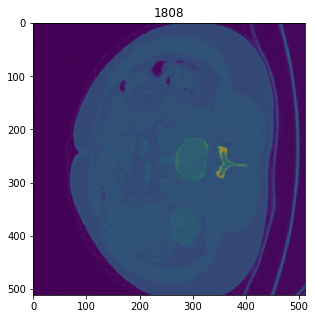

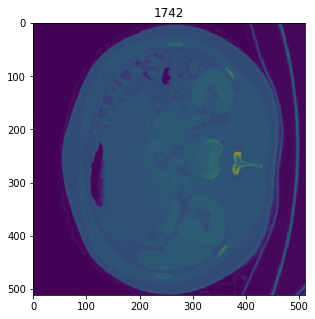

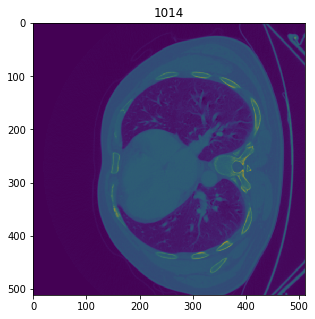

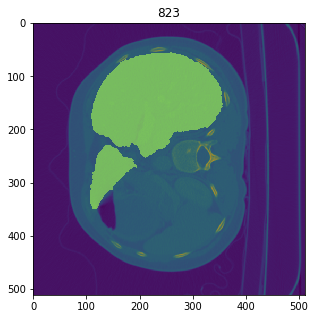

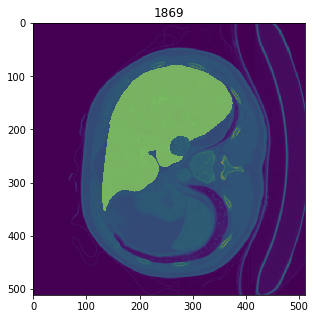

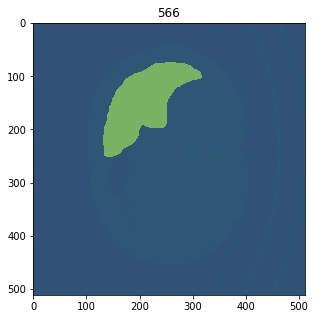

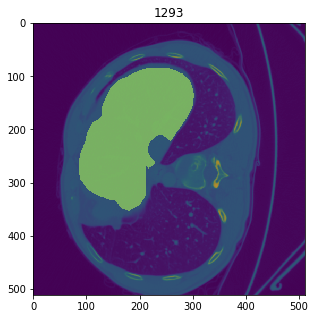

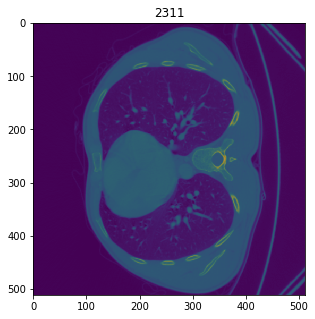

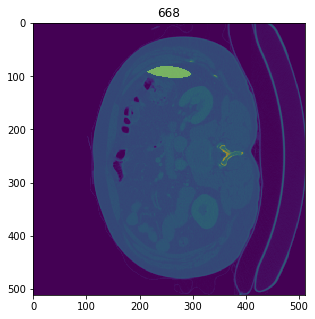

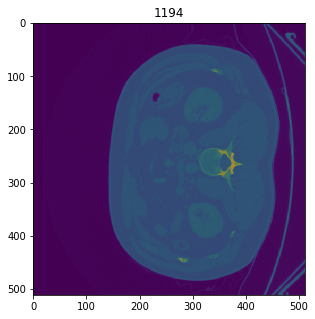

In [10]:
def show_img(n):
    """
    Show the n-th image with its segmentation mask.
    
    """
    plt.figure(figsize=(5,5))
    plt.imshow(Image.open(X[0][n]))
    plt.imshow(Image.open(y[0][n]), alpha=0.4)
    plt.title(n)

# let's look at 10 random images
for i in np.random.choice(np.arange(y.shape[0]), 10):
    show_img(i)

In [0]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, shuffle=True, random_state=SEED)

In [0]:
from keras.models import Model, load_model
from keras import backend as K

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

# (channels, rows, cols).
K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    """
    A simple dice metric over true and predicted tensors.
    We do not calculate dice axis-based, instead of this we calculate total dice
    for the whole batch. It is simpler, when the result is the same as after 
    'fair' calculation of dice for each sample and averaging of it over the batch.
    dice = (2* |true ∩ pred|) / (|true|+|pred|)
    Lies in the interval [0, 1]
    """
    smooth=1e-20 # smoothing for a case when true + pred = 0
    intersection = K.sum(y_true * y_pred)
    return (2*intersection+smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    """
    Loss function with dice coefficient. The higher dice the better, hence loss
    may be just "-dice" or "1-dice" as here, for better aesthetics, as dice lies
    in the interval [0,1].
    """
    return 1 - dice_coef(y_true, y_pred)
  
def jaccard_coef(y_true, y_pred):
    """
    Jaccard coefficient. Estimates as Intersection over Union ratio.
    Similarly to dice_coef, is calculated for the whole batch.
    """
    smooth = 1e-20
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true + y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def jaccard_coef_loss(y_true, y_pred):
    """
    The same loss as dice, but with jaccard coefficient instead.
    """
    return 1 - jaccard_coef(y_true, y_pred)

def unet(img_channels, image_rows, image_cols, neurons=16):
    inputs = Input((img_channels, image_rows, image_cols))
    conv1 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(neurons*16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(neurons*16, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    up6 = Dropout(0.5)(up6)
    conv6 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    up7 = Dropout(0.5)(up7)
    conv7 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    up8 = Dropout(0.5)(up8)
    conv8 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    up9 = Dropout(0.5)(up9)
    conv9 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Dropout(0.5)(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv10)

    model = Model(inputs=[inputs], outputs=[conv10])
    optimizer=RMSprop(lr=1e-3)

    model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [0]:
def plot_history(history, scoring='dice_coef'):
    dct = history.history
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(dct['loss'], label='loss')
    ax[0].plot(dct['val_loss'], label='val_loss')
    ax[1].plot(dct[scoring], label=scoring)
    ax[1].plot(dct[f'val_{scoring}'], label=f'val_{scoring}')
    if 'lr' in dct:
        ax[2].plot(dct['lr'], label='lr')
    [a.legend() for a in ax]

In [14]:
X_train.shape, y_train.shape

((1941, 1), (1941, 1))

In [0]:
w_size = np.array(Image.open(X[0][0])).shape[0]
model = unet(1, w_size, w_size, 8)

In [0]:
X_tr, X_val, y_tr, y_val = tts(X_train, y_train, test_size=0.1, shuffle=True, random_state=SEED)

In [26]:
%%time
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stop = EarlyStopping(patience=30)

gen_train_params = {
    'rotation_range':10,
    'fill_mode':'reflect',
#     'zoom_range':0.5,
#     'horizontal_flip':True,
#     'vertical_flip':True,
#     'width_shift_range': 1.,
#     'height_shift_range': 1.,
}
idg_train_data = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
                                    **gen_train_params,
                             )
idg_train_mask = ImageDataGenerator(rescale=1./255, 
                                    **gen_train_params)

train_gen_params = {
    'x_col': 0,
    'target_size': (512, 512), 
    'color_mode': 'grayscale',
    'batch_size': 4,
    'class_mode': None,
    'shuffle': True,
    'seed': SEED,
}
val_gen_params = train_gen_params.copy()
val_gen_params['shuffle'] = False
val_gen_params['batch_size'] = 1

data_train_generator = idg_train_data.flow_from_dataframe(X_tr, **train_gen_params)
mask_train_generator = idg_train_mask.flow_from_dataframe(y_tr, **train_gen_params)
train_generator = zip(data_train_generator, (x.astype(np.uint8) for x in mask_train_generator))

idg_test_data = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
                                  )
idg_test_mask = ImageDataGenerator(rescale=1./255)
data_test_generator = idg_test_data.flow_from_dataframe(X_val,**val_gen_params)
mask_test_generator = idg_test_mask.flow_from_dataframe(y_val, **val_gen_params)
test_generator = zip(data_test_generator, (x.astype(np.uint8) for x in mask_test_generator))


history = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=X_tr.shape[0]//train_gen_params['batch_size'],
    validation_steps=X_val.shape[0] // val_gen_params['batch_size'],
    verbose=1,
    epochs=150,
    callbacks=[early_stop, reduce_lr]
)

Found 1746 validated image filenames.
Found 1746 validated image filenames.
Found 195 validated image filenames.
Found 195 validated image filenames.
Epoch 1/150
436/436 [==============================] - 114s 261ms/step - loss: 0.3669 - dice_coef: 0.6331 - val_loss: 0.4132 - val_dice_coef: 0.5868
Epoch 2/150
436/436 [==============================] - 110s 252ms/step - loss: 0.2949 - dice_coef: 0.7051 - val_loss: 0.3517 - val_dice_coef: 0.6483
Epoch 3/150
436/436 [==============================] - 110s 252ms/step - loss: 0.2547 - dice_coef: 0.7453 - val_loss: 0.3164 - val_dice_coef: 0.6836
Epoch 4/150
436/436 [==============================] - 109s 251ms/step - loss: 0.2321 - dice_coef: 0.7679 - val_loss: 0.2962 - val_dice_coef: 0.7038
Epoch 5/150
436/436 [==============================] - 110s 251ms/step - loss: 0.2205 - dice_coef: 0.7795 - val_loss: 0.2831 - val_dice_coef: 0.7169
Epoch 6/150
436/436 [==============================] - 109s 251ms/step - loss: 0.1960 - dice_coef: 0.8040

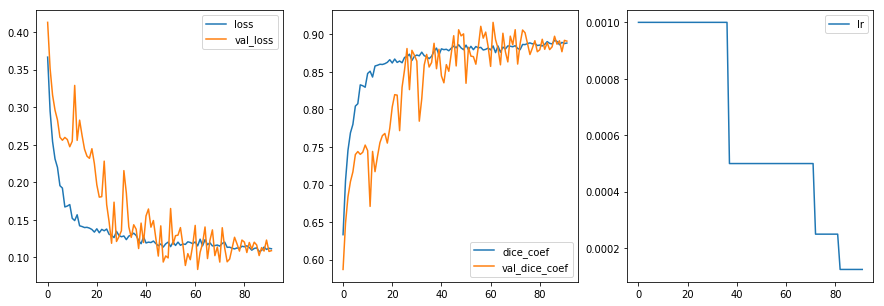

In [27]:
plot_history(history)

In [0]:
model.save(path('model_8_92.weights', 1))
# model.load_weights(path('weights_new_4_100.weights', 1))

In [0]:
def evaluate(x_names, y_names, set_name='evaluating', plot_pairs=0):
    """
    Evaluating of segmentation quality over the given dataset.
    Parameters:
    -----------
    x_names : iterable of TIFF images filenames (scans)
    y_names : iterable of PNG images filenames (masks)
    set_name : str, name of the set
    plot_pairs : int, number of pairs (ground truth masked image | prediction masked image) to show
    """
    val_gen_params['batch_size'] = 1
    print(set_name)
    dices = []
    jccrs = []
    mdices = []
    mjccrs = []
    data_g = idg_test_data.flow_from_dataframe(x_names, **val_gen_params)
    mask_g = idg_test_mask.flow_from_dataframe(y_names, **val_gen_params)
    for i, image_mask in enumerate(zip(tqdm_notebook(data_g), mask_g)):
        if i > x_names.shape[0] // val_gen_params['batch_size']:
            break
        image, mask = image_mask
        if mask.max() == 0:
            continue
        p = model.predict(image).astype('uint8')
        dice = dc(p, mask)
        dices.append(dice)
        try:
            jccr = jc(p, mask)
        except ZeroDivisionError as e:
#           jc = intersection / union. If union = 0, hence true = pred = 0, segmentation is perfect
            jccr = 1
        jccrs.append(jccr)

        if plot_pairs:
            plot_pairs -= 1
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5,10))
            ax1.imshow(image.squeeze())
            ax1.imshow(mask.squeeze(), alpha=0.5, cmap='autumn')
            ax1.set_title('ground')
            ax2.imshow(image.squeeze())
            ax2.imshow(p.squeeze(), alpha=0.5, cmap='autumn')
            ax2.set_title('predicted, dc={0:.2f}'.format(dice))
            plt.show()
        
    print('dice:', np.mean(dices))
    print('jccr:', np.mean(jccrs))
    print('-------------')
    return dice

TR SET
Found 1746 validated image filenames.
Found 1746 validated image filenames.


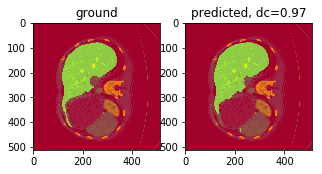

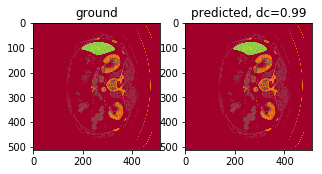

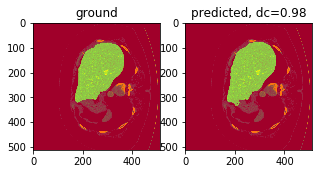

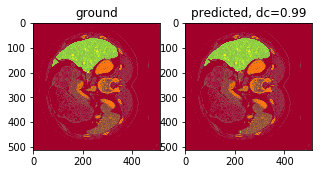

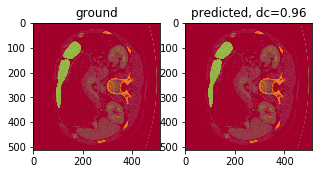

dice: 0.939611809642249
jccr: 0.9091004870975551
-------------
VAL SET
Found 195 validated image filenames.
Found 195 validated image filenames.


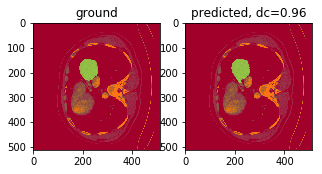

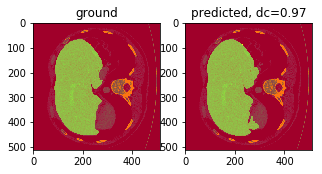

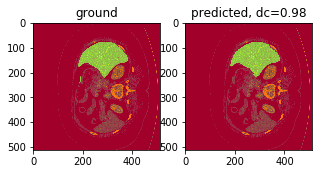

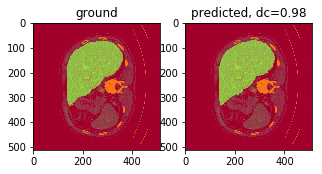

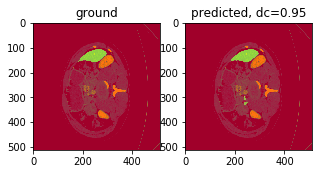

dice: 0.9414158485834644
jccr: 0.9076849888570784
-------------
TEST SET
Found 832 validated image filenames.
Found 832 validated image filenames.


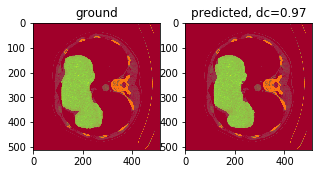

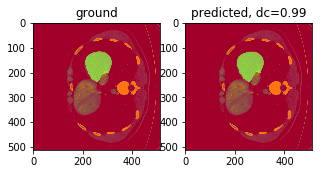

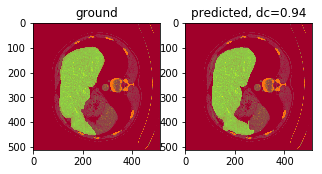

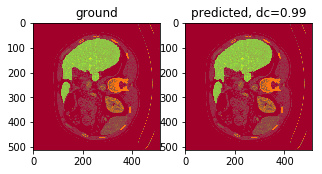

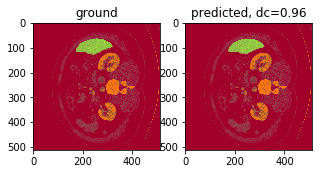

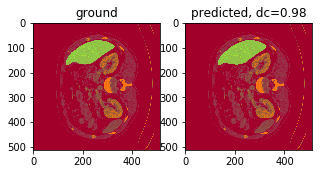

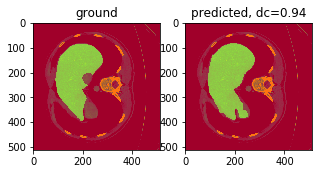

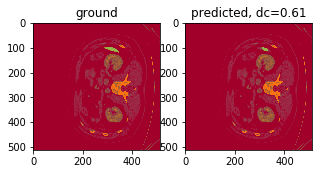

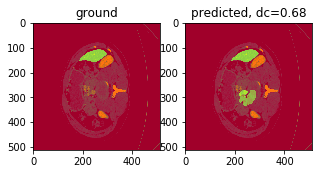

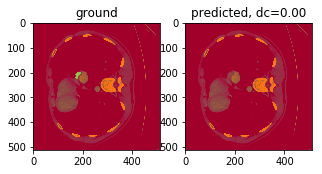

dice: 0.9309724365073262
jccr: 0.8976678421346307
-------------
CPU times: user 59.6 s, sys: 22.1 s, total: 1min 21s
Wall time: 1min 12s


In [63]:
%%time
evaluate(X_tr, y_tr, 'TR SET', 5)
evaluate(X_val, y_val, 'VAL SET', 5)
evaluate(X_test, y_test, 'TEST SET', 10)